In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.3


In [2]:
K.set_image_data_format('channels_first')


In [3]:
N_Cls = 10
inDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [4]:

def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)


def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


In [5]:
stick_all_train()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


In [6]:
def make_val():
    print "let's pick some samples for validation"
    img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

    np.save(inDir + '/data/x_tmp_%d' % N_Cls, x)
    np.save(inDir + '/data/y_tmp_%d' % N_Cls, y)

In [7]:
make_val()

let's pick some samples for validation
(1035, 8, 160, 160) (1035, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [8]:

def get_unet():
    inputs = Input((8,ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


def calc_jacc(model):
    img = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls), np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)
    img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights(inDir + '/weights/unet_10_jk0.8045')
    model_checkpoint = ModelCheckpoint(inDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, epochs=2, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(inDir + '/weights/unet_10_jk%.4f' % score)

    return model


def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(inDir + '/msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id


def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load(inDir + '/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(inDir + '/subm/subm_unet_8045.csv', index=False)


def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights(inDir + '/weights/unet_10_jk0.8045')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()



In [10]:
inputs = Input((ISZ, ISZ,8))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 8, 160, 160)       0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 32, 160, 160)      2336      
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 160, 160)      9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 80, 80)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 64, 80, 80)        18496     
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 64, 80, 80)        36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 40, 40)        0         
__________

In [28]:
x_val, y_val = np.load(inDir + '/data/x_tmp_%d.npy' % N_Cls), np.load(inDir + '/data/y_tmp_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

In [29]:
x_trn, y_trn = get_patches(img, msk)

(3439, 8, 160, 160) (3439, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [33]:
x_val.shape, y_val.shape

((1011, 8, 160, 160), (1011, 10, 160, 160))

In [36]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True, validation_data=(x_val, y_val))

Train on 3439 samples, validate on 1011 samples
Epoch 1/1
3439/3439 [==============================] - 386s - loss: 0.2926 - jaccard_coef: 0.0463 - jaccard_coef_int: 0.0174 - acc: 0.8883 - val_loss: 0.1887 - val_jaccard_coef: 0.0448 - val_jaccard_coef_int: 3.3715e-04 - val_acc: 0.9236


In [9]:
model = train_net()

start train net
(3439, 8, 160, 160) (3439, 10, 160, 160) 1.0 -1.0 1.0 0.0
Train on 3439 samples, validate on 1035 samples
Epoch 1/2
3439/3439 [==============================] - 391s - loss: 0.0893 - jaccard_coef: 0.2224 - jaccard_coef_int: 0.2154 - acc: 0.9687 - val_loss: 0.0776 - val_jaccard_coef: 0.2532 - val_jaccard_coef_int: 0.2442 - val_acc: 0.9725
Epoch 2/2
3439/3439 [==============================] - 376s - loss: 0.0747 - jaccard_coef: 0.2724 - jaccard_coef_int: 0.2698 - acc: 0.9733 - val_loss: 0.0709 - val_jaccard_coef: 0.2937 - val_jaccard_coef_int: 0.2953 - val_acc: 0.9749
(3516, 8, 160, 160) (3516, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1035, 10, 160, 160) (1035, 10, 160, 160)
0 0.833874188406 0.4
1 0.643956376611 0.2
2 0.855818228441 0.5
3 0.416823671498 0.5
4 0.516591249344 0.4
5 0.901819295979 0.6
6 0.978429053747 0.3
7 0.965467794986 0.7
8 0.98652173913 0.3
9 0.945760869565 0.2
val jk 0.804506246771


In [10]:
model = train_net()

start train net
(3551, 8, 160, 160) (3551, 10, 160, 160) 1.0 -1.0 1.0 0.0
Train on 3551 samples, validate on 1039 samples
Epoch 1/2
3551/3551 [==============================] - 386s - loss: 0.2494 - jaccard_coef: 0.0460 - jaccard_coef_int: 0.0139 - acc: 0.8956 - val_loss: 0.1871 - val_jaccard_coef: 0.0468 - val_jaccard_coef_int: 0.0012 - val_acc: 0.9228
Epoch 2/2
3551/3551 [==============================] - 380s - loss: 0.1824 - jaccard_coef: 0.0533 - jaccard_coef_int: 0.0203 - acc: 0.9230 - val_loss: 0.1802 - val_jaccard_coef: 0.0565 - val_jaccard_coef_int: 0.0118 - val_acc: 0.9236
(3551, 8, 160, 160) (3551, 10, 160, 160) 1.0 -1.0 1.0 0.0
(1039, 10, 160, 160) (1039, 10, 160, 160)
0 0.734618623677 0.9
1 0.646691530318 0.4
2 0.816782964389 0.5
3 0.397479547642 0.5
4 0.177044627004 0.2
5 0.466788979788 0.7
6 0.946649422522 0.5
7 0.961266843118 0.4
8 0.988949711261 0.3
9 0.948147256978 0.5
val jk 0.70844195067


In [10]:
# model = train_net()
score, trs = calc_jacc(model)

(1035, 10, 160, 160) (1035, 10, 160, 160)
0 0.833874188406 0.4
1 0.643956376611 0.2
2 0.855818228441 0.5
3 0.416823671498 0.5
4 0.516591249344 0.4
5 0.901819295979 0.6
6 0.978429053747 0.3
7 0.965467794986 0.7
8 0.98652173913 0.3
9 0.945760869565 0.2


In [11]:
predict_test(model, trs)

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0


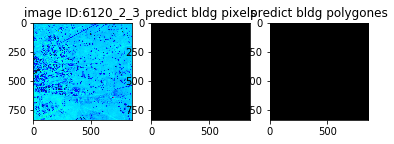

In [12]:
check_predict()

In [13]:
make_submit()

Self-intersection at or near point 443.97894736842107 309.38947368421054


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
0


Self-intersection at or near point 270.51162790697674 236.02325581395348
Self-intersection at or near point 494.69767441860466 97.069767441860463
Self-intersection at or near point 309.40983606557376 177.37704918032787
Self-intersection at or near point 809.96518375241783 525.61702127659578
Self-intersection at or near point 181.0952380952381 597.23809523809518
Self-intersection at or near point 338.10738255033556 601.93288590604027
Self-intersection at or near point 840.59322033898309 548.30508474576266
Self-intersection at or near point 726.18461538461543 760.55384615384617
Self-intersection at or near point 317.39999999999998 6.5999999999999996
Self-intersection at or near point 819.06896551724139 337.37931034482756
Self-intersection at or near point 818.192118226601 763.64039408866995
Self-intersection at or near point 675.38461538461536 703.30769230769226
Self-intersection at or near point 752.42335766423355 88.992700729927009
Self-intersection at or near point 1.8476821192052979 

100


Self-intersection at or near point 519.32000000000005 468.63999999999999
Self-intersection at or near point 796.27999999999997 16
Self-intersection at or near point 844.35570469798654 820.40939597315435
Self-intersection at or near point 508.62686567164178 726.3432835820895
Self-intersection at or near point 349.08450704225351 501.90140845070425
Self-intersection at or near point 822.40865384615381 112.9375
Self-intersection at or near point 627.16666666666663 321
Self-intersection at or near point 833.34841628959271 171.02262443438914
Self-intersection at or near point 749.27848101265818 320.33417721518987
Ring Self-intersection at or near point 480 180
Self-intersection at or near point 453.55555555555554 402.5
Self-intersection at or near point 790.97058823529414 161.02941176470588
Self-intersection at or near point 714.14308426073137 344.60254372019079
Self-intersection at or near point 502.80865224625626 832.28119800332775
Self-intersection at or near point 328.30232558139534 800.

200


Self-intersection at or near point 755.96078431372553 176.94117647058823
Self-intersection at or near point 688.88541666666663 459.0625
Self-intersection at or near point 753.74641148325361 516.68421052631584
Self-intersection at or near point 537.71428571428567 323.71428571428572
Self-intersection at or near point 843.08064516129036 280.88709677419354
Self-intersection at or near point 154.99065420560748 468.69158878504675
Self-intersection at or near point 772.80565371024738 572.9293286219081
Self-intersection at or near point 845.83333333333337 147.33333333333334
Self-intersection at or near point 660.58947368421047 371.25263157894739
Self-intersection at or near point 810.63736263736268 148.96703296703296
Self-intersection at or near point 826.12 324.72000000000003
Self-intersection at or near point 464.14285714285717 155
Self-intersection at or near point 803.68811881188117 652.96039603960401
Self-intersection at or near point 845.36363636363637 251.81818181818181
Self-intersectio

300


Self-intersection at or near point 764.14285714285711 751.85714285714289
Self-intersection at or near point 655.63636363636363 823
Self-intersection at or near point 788.36900369003695 289.5608856088561
Self-intersection at or near point 831.06759443339956 768.93439363817095
Self-intersection at or near point 643.53312302839117 675.64668769716093
Self-intersection at or near point 819 542.27272727272725
Self-intersection at or near point 696.59322033898309 744.71186440677968
Ring Self-intersection at or near point 478 664
Self-intersection at or near point 141.1764705882353 19.764705882352942
Self-intersection at or near point 637.34042553191489 816.37234042553189
Self-intersection at or near point 289.07865168539325 644.03370786516859
Self-intersection at or near point 477.80260303687635 212.96963123644252
Self-intersection at or near point 47.040404040404042 800.32323232323233
Self-intersection at or near point 476.87012987012986 701.01298701298697
Self-intersection at or near point 

400


Self-intersection at or near point 676.54999999999995 835.37
Self-intersection at or near point 830.89320388349518 589.82524271844659
Self-intersection at or near point 133.75 637.6875
Self-intersection at or near point 151.46494464944649 438.2029520295203
Self-intersection at or near point 622.13725490196077 688
Self-intersection at or near point 831.37864077669906 649.92233009708741
Self-intersection at or near point 699.89473684210532 816.21052631578948
Self-intersection at or near point 371.23529411764707 714.70000000000005
Self-intersection at or near point 680.61318051575927 494.52722063037248
Self-intersection at or near point 49 533
Self-intersection at or near point 847.66129032258061 699.56451612903231
Self-intersection at or near point 810.17365269461072 438.74850299401197
Self-intersection at or near point 280.87969924812029 262.4736842105263
Self-intersection at or near point 823.79999999999995 301.14999999999998
Self-intersection at or near point 157.76363636363635 152.12

500


Self-intersection at or near point 397.05780346820808 832.81695568400767
Self-intersection at or near point 821.03875968992247 38.046511627906973
Self-intersection at or near point 821 692.05555555555554
Self-intersection at or near point 845.06153846153848 233.56923076923076
Self-intersection at or near point 842.08071748878922 700.69955156950675
Self-intersection at or near point 178.77272727272728 504.04545454545456
Self-intersection at or near point 812.46153846153845 258.07692307692309
Self-intersection at or near point 574.25 811.5
Self-intersection at or near point 846.15999999999997 213.12
Self-intersection at or near point 373.20454545454544 734.36742424242425
Self-intersection at or near point 821.66515837104077 77.425339366515843
Self-intersection at or near point 343.55000000000001 349.25
Self-intersection at or near point 790.93103448275861 132.13793103448276
Self-intersection at or near point 754.39130434782612 510.6521739130435
Self-intersection at or near point 813.2481

600


Self-intersection at or near point 801.92035398230087 337.35398230088498
Self-intersection at or near point 798.86956521739125 579.2086956521739
Self-intersection at or near point 810.94339622641508 389.07547169811323
Self-intersection at or near point 765.29032258064512 336.09677419354841
Self-intersection at or near point 546.70103092783506 558.2783505154639
Self-intersection at or near point 810.60573476702507 237.27598566308245
Self-intersection at or near point 157.40000000000001 785.20000000000005
Self-intersection at or near point 34.307692307692307 6.2564102564102564
Self-intersection at or near point 818.61971830985919 673.04929577464793
Self-intersection at or near point 812 110.18181818181819
Self-intersection at or near point 560.05479452054794 457.09589041095893
Self-intersection at or near point 205.1404255319149 202.01276595744682
Self-intersection at or near point 785.20481927710841 7.7590361445783129
Self-intersection at or near point 313.11111111111109 727.5
Self-inte

700


Self-intersection at or near point 520.35000000000002 672.64999999999998
Self-intersection at or near point 817.72727272727275 47.81818181818182
Self-intersection at or near point 820.87719298245611 355.94736842105266
Self-intersection at or near point 35 483.27272727272725
Self-intersection at or near point 226.42700729927006 75.748175182481745
Self-intersection at or near point 799.11904761904759 555.16666666666663
Self-intersection at or near point 20.166666666666668 99.833333333333329
Self-intersection at or near point 679.32751091703062 139.73799126637556
Self-intersection at or near point 12.739130434782609 830.43478260869563
Self-intersection at or near point 794.80079681274901 303.47808764940237
Self-intersection at or near point 169.52941176470588 816.70588235294122
Self-intersection at or near point 563.29787234042556 349.55319148936172
Self-intersection at or near point 444.09876543209879 308.44444444444446
Self-intersection at or near point 642.41772151898738 786.3037974683

800


Self-intersection at or near point 682.936170212766 25.48936170212766
Self-intersection at or near point 777.50649350649348 652.68831168831173
Self-intersection at or near point 659.77325581395348 476.62790697674421
Self-intersection at or near point 42.307692307692307 24.692307692307693
Self-intersection at or near point 609.58490566037733 115.05660377358491
Self-intersection at or near point 214.02857142857144 336.65714285714284
Self-intersection at or near point 616.82352941176475 22.705882352941178
Self-intersection at or near point 793.53246753246754 606.28571428571433
Self-intersection at or near point 736.47352024922122 477.69158878504675
Self-intersection at or near point 380.79729729729729 116.02702702702703
Self-intersection at or near point 512.88636363636363 798.52272727272725
Self-intersection at or near point 784.89423076923072 796.61217948717945
Self-intersection at or near point 291.07272727272726 822.69090909090914
Self-intersection at or near point 736.88163265306127 

900


Self-intersection at or near point 173.94230769230768 604.86538461538464
Self-intersection at or near point 794.95041322314046 369.28099173553721
Self-intersection at or near point 23.210300429184549 785.94420600858371
Self-intersection at or near point 840.54109589041093 379.46575342465752
Self-intersection at or near point 649.38766519823787 540.28193832599118
Ring Self-intersection at or near point 694 799
Self-intersection at or near point 819.13698630136992 152.1917808219178
Self-intersection at or near point 845.63617463617459 799.34095634095638
Self-intersection at or near point 841.52054794520552 616.2465753424658
Self-intersection at or near point 501.65329512893982 141.60458452722062
Self-intersection at or near point 317.42975206611573 128.86776859504133
Self-intersection at or near point 843.72727272727275 232.45454545454547
Self-intersection at or near point 799.37209302325584 415.09302325581393
Self-intersection at or near point 98.991189427312776 300.14977973568284
Self-

1000


Self-intersection at or near point 847.91240875912411 612.07299270072997
Self-intersection at or near point 846.73539518900338 652.92783505154637
Self-intersection at or near point 86.219780219780219 120.27472527472527
Self-intersection at or near point 564.42222222222222 36.94222222222222
Self-intersection at or near point 823.29213483146066 376.13483146067415
Self-intersection at or near point 711.95652173913038 699.56521739130437
Self-intersection at or near point 845.89189189189187 578.94594594594594
Self-intersection at or near point 122.12865497076024 594.32163742690057
Self-intersection at or near point 843.8730158730159 431.47619047619048
Self-intersection at or near point 826.2389380530974 439.46902654867256
Self-intersection at or near point 773 699
Self-intersection at or near point 806.60000000000002 731.29999999999995
Self-intersection at or near point 801.10071942446041 322.51079136690646
Self-intersection at or near point 478.02272727272725 677.40909090909088
Self-inters

1100


Self-intersection at or near point 613.07317073170736 23.780487804878049
Self-intersection at or near point 785.58333333333337 495.58333333333331
Self-intersection at or near point 318.54285714285714 783.17142857142858
Self-intersection at or near point 620.66037735849056 754.67924528301887
Self-intersection at or near point 627.66666666666663 785
Self-intersection at or near point 214.12727272727273 103.40000000000001
Self-intersection at or near point 102.16216216216216 294.89189189189187
Self-intersection at or near point 714.10434782608695 86.826086956521735
Self-intersection at or near point 744 797.5
Ring Self-intersection at or near point 848 379
Ring Self-intersection at or near point 617 666
Self-intersection at or near point 711.37070524412297 109.36889692585895
Self-intersection at or near point 797.64912280701753 139.19298245614036
Ring Self-intersection at or near point 558 710
Self-intersection at or near point 817.69230769230774 377.73076923076923
Self-intersection at or

1200


Self-intersection at or near point 148.46666666666667 681.42666666666662
Self-intersection at or near point 677.29729729729729 209.35135135135135
Ring Self-intersection at or near point 160 358
Self-intersection at or near point 806.71428571428567 607.85714285714289
Self-intersection at or near point 584.23076923076928 682.76923076923072
Self-intersection at or near point 530.8350515463917 413.49484536082474
Self-intersection at or near point 687.92920353982299 793.66371681415933
Self-intersection at or near point 770.25641025641028 678.56410256410254
Self-intersection at or near point 586.58333333333337 153.55555555555554
Self-intersection at or near point 789.20000000000005 342
Self-intersection at or near point 778.3125 825.4375
Self-intersection at or near point 785.25 281.25
Self-intersection at or near point 637.00980392156862 644.57843137254906
Self-intersection at or near point 11.964601769911505 303.59292035398232
Self-intersection at or near point 643.83870967741939 816.35483

1300


Self-intersection at or near point 832.6521739130435 368.91304347826087
Self-intersection at or near point 387.08080808080808 598.53535353535358
Self-intersection at or near point 807 733.33333333333337
Self-intersection at or near point 836.42857142857144 64.857142857142861
Self-intersection at or near point 692.31818181818187 49.363636363636367
Self-intersection at or near point 684.42307692307691 801.63461538461536
Self-intersection at or near point 111 484
Self-intersection at or near point 639.24888888888893 607.75999999999999
Self-intersection at or near point 795 595.37037037037032
Self-intersection at or near point 844.18181818181813 217.81818181818181
Self-intersection at or near point 657.81967213114751 684.44262295081967
Self-intersection at or near point 783.44700460829495 256.64516129032256
Self-intersection at or near point 840.28301886792451 830.20754716981128
Self-intersection at or near point 810.46285714285716 690.08000000000004
Self-intersection at or near point 747.

1400


Self-intersection at or near point 760.93023255813955 194.46511627906978
Self-intersection at or near point 846.56108597285072 699.52036199095028
Self-intersection at or near point 776.89090909090908 185.18181818181819
Self-intersection at or near point 716.17391304347825 735.78595317725751
Self-intersection at or near point 628 404.5
Self-intersection at or near point 632.05405405405406 643.67567567567562
Self-intersection at or near point 849.08431163287082 754.03521878335107
Self-intersection at or near point 647 479
Self-intersection at or near point 668.78431372549016 367.74117647058824
Self-intersection at or near point 750.08571428571429 20.085714285714285
Self-intersection at or near point 797.38562091503263 693.04575163398692
Self-intersection at or near point 375.88888888888891 289.22222222222223
Self-intersection at or near point 747.00651465798046 663.95765472312701
Self-intersection at or near point 246 675
Self-intersection at or near point 329.7358490566038 707.716981132

1500


Ring Self-intersection at or near point 450 27
Self-intersection at or near point 671.82608695652175 535.17391304347825
Self-intersection at or near point 401.88 301.53411764705885
Self-intersection at or near point 742.62222222222226 112.73333333333333
Self-intersection at or near point 830.70078740157476 812.29133858267721
Self-intersection at or near point 464.61764705882354 82.07352941176471
Self-intersection at or near point 825.53846153846155 261.76923076923077
Self-intersection at or near point 802.39754098360652 94.889344262295083
Self-intersection at or near point 766.59550561797755 743.29213483146066
Self-intersection at or near point 821.64285714285711 244.64285714285714
Self-intersection at or near point 12.012987012987013 684.87012987012986
Self-intersection at or near point 579.625 672.875
Self-intersection at or near point 640.96000000000004 817.67999999999995
Self-intersection at or near point 844.56521739130437 41.956521739130437
Self-intersection at or near point 672.

1600


Self-intersection at or near point 619.53719008264466 590.04132231404958
Self-intersection at or near point 839.37931034482756 450.9655172413793
Self-intersection at or near point 346.20689655172413 482.4942528735632
Self-intersection at or near point 711.26315789473688 645.31578947368416
Self-intersection at or near point 628.77894736842109 165.45263157894738
Self-intersection at or near point 563.79999999999995 660.86666666666667
Self-intersection at or near point 264.28571428571428 177
Self-intersection at or near point 576.5272727272727 18.645454545454545
Self-intersection at or near point 781.625 548.5
Self-intersection at or near point 92.511627906976742 136.53488372093022
Ring Self-intersection at or near point 441 589
Self-intersection at or near point 328 466
Self-intersection at or near point 560.82926829268297 499.48780487804879
Self-intersection at or near point 830.27586206896547 633.72413793103453
Self-intersection at or near point 759.76610169491528 734.77966101694915
Se

1700


Self-intersection at or near point 552.38095238095241 25.142857142857142
Self-intersection at or near point 818.8360655737705 205.03278688524591
Self-intersection at or near point 511.86227544910179 129.46107784431138
Self-intersection at or near point 287.44525547445255 613.20437956204375
Self-intersection at or near point 766.51851851851848 334.81481481481484
Self-intersection at or near point 0.29999999999999999 264.39999999999998
Self-intersection at or near point 624.88235294117646 539.48739495798316
Self-intersection at or near point 800.73333333333335 138.55555555555554
Self-intersection at or near point 325 189
Self-intersection at or near point 333.82051282051282 310.97435897435895
Self-intersection at or near point 827.01056338028172 340.8098591549296
Self-intersection at or near point 845.35000000000002 789.89999999999998
Self-intersection at or near point 207.40000000000001 819.67999999999995
Self-intersection at or near point 826.87203791469199 483.26540284360192
Ring Self

1800


Self-intersection at or near point 825.0526315789474 782.15789473684208
Self-intersection at or near point 92.555555555555557 98.25252525252526
Self-intersection at or near point 834.33333333333337 741.66666666666663
Self-intersection at or near point 154.91275167785236 199.61073825503357
Self-intersection at or near point 839.09448818897636 806.84645669291342
Self-intersection at or near point 536.40594059405942 627.85148514851483
Self-intersection at or near point 845 380
Self-intersection at or near point 475 77.833333333333329
Self-intersection at or near point 527.052812858783 639.06314580941444
Self-intersection at or near point 778.10067114093965 630.13422818791946
Self-intersection at or near point 718.05725190839689 300.00763358778624
Self-intersection at or near point 745 267
Self-intersection at or near point 3.6842105263157894 685.63157894736844
Self-intersection at or near point 845.47133757961785 407.71974522292993
Self-intersection at or near point 417.85245901639342 569

1900


Self-intersection at or near point 481.20817843866172 148.42750929368029
Self-intersection at or near point 341.00581395348837 452.44186046511629
Self-intersection at or near point 686.61403508771934 401.61842105263156
Self-intersection at or near point 402.45454545454544 58
Self-intersection at or near point 697.9655172413793 296.71264367816093
Self-intersection at or near point 823.17834394904457 541.50955414012742
Self-intersection at or near point 137.58823529411765 805.47058823529414
Self-intersection at or near point 70.485436893203882 648.26213592233012
Self-intersection at or near point 841.5151515151515 331.45454545454544
Self-intersection at or near point 843.5454545454545 69.766233766233768
Self-intersection at or near point 837.4545454545455 387.66666666666669
Self-intersection at or near point 153.10526315789474 53
Self-intersection at or near point 773.88679245283015 54.698113207547166
Self-intersection at or near point 800.37142857142862 760.85714285714289
Self-intersect

2000


Self-intersection at or near point 806.13475177304963 810.14893617021278
Self-intersection at or near point 573.69716088328073 701.67192429022077
Self-intersection at or near point 748.27272727272725 794
Ring Self-intersection at or near point 826 151
Self-intersection at or near point 579.08695652173913 138.78260869565219
Self-intersection at or near point 792.75999999999999 723
Self-intersection at or near point 730.71176470588239 122.67647058823529
Self-intersection at or near point 705 75.150000000000006
Self-intersection at or near point 830.16666666666663 428.83333333333331
Self-intersection at or near point 746.68421052631584 138.80701754385964
Self-intersection at or near point 829.89473684210532 34.368421052631582
Self-intersection at or near point 425.52941176470586 292.15032679738562
Self-intersection at or near point 697.7358490566038 769.18867924528297
Self-intersection at or near point 454 202
Self-intersection at or near point 627 686
Self-intersection at or near point 8

2100


Self-intersection at or near point 79.700404858299592 98.829959514170042
Self-intersection at or near point 838.63043478260875 723.6521739130435
Self-intersection at or near point 572.79614767255214 440.92295345104333
Ring Self-intersection at or near point 128 797
Self-intersection at or near point 841.92682926829264 595.29268292682923
Self-intersection at or near point 738.39999999999998 296.89999999999998
Self-intersection at or near point 624.92307692307691 151.94871794871796
Self-intersection at or near point 799.32203389830511 133.40677966101694
Self-intersection at or near point 692.78688524590166 556.57377049180332
Self-intersection at or near point 841.18181818181813 427.63636363636363
Self-intersection at or near point 630.61538461538464 437.61538461538464
Self-intersection at or near point 789.63636363636363 508
Self-intersection at or near point 812.35897435897436 648.71794871794873
Self-intersection at or near point 720.54368932038835 313.11650485436894
Self-intersection a

2200


Self-intersection at or near point 816.75999999999999 196.16
Self-intersection at or near point 751.94117647058829 474.9264705882353
Self-intersection at or near point 541.22608695652173 342.03478260869565
Self-intersection at or near point 833.08309455587391 801.6045845272206
Self-intersection at or near point 833.22055674518197 410.41541755888653
Self-intersection at or near point 681.73621103117512 748.29016786570742
Self-intersection at or near point 367.70833333333331 248.30555555555554
Self-intersection at or near point 833.73749999999995 743.61249999999995
Self-intersection at or near point 813.36842105263156 634.47368421052636
Self-intersection at or near point 415 708
Self-intersection at or near point 88.142857142857139 166.42857142857142
Self-intersection at or near point 192.04545454545453 369.90909090909093
Self-intersection at or near point 811.48979591836735 448.12244897959181
Self-intersection at or near point 459.06666666666666 377.39999999999998
Self-intersection at o

2300


Self-intersection at or near point 720.08955223880594 29.149253731343283
Self-intersection at or near point 820.34262948207174 29.358565737051794
Self-intersection at or near point 322.4854881266491 30.575197889182057
Self-intersection at or near point 764.87272727272727 393.90909090909093
Self-intersection at or near point 627.14851485148517 638.25742574257424
Self-intersection at or near point 804.09756097560978 675.51219512195121
Self-intersection at or near point 845.9375 103.875
Self-intersection at or near point 656.67694204685574 55.278668310727497
Self-intersection at or near point 846.4545454545455 819.63636363636363
Self-intersection at or near point 209.16438356164383 378.1917808219178
Self-intersection at or near point 829.76923076923072 343.53846153846155
Self-intersection at or near point 631.54618473895584 184.62248995983936
Self-intersection at or near point 297.9795918367347 475.50145772594755
Self-intersection at or near point 798.19463087248323 178.95973154362417
Sel

2400


Self-intersection at or near point 315.5462962962963 62.157407407407405
Self-intersection at or near point 844.60683760683764 87.73504273504274
Ring Self-intersection at or near point 772 47
Self-intersection at or near point 759.81818181818187 684.81818181818187
Self-intersection at or near point 179.44859813084113 747.39252336448601
Self-intersection at or near point 825.36305732484072 753.39490445859872
Self-intersection at or near point 206 179
Self-intersection at or near point 609.5454545454545 256.45454545454544
Self-intersection at or near point 818.47169811320759 331.39622641509436
Self-intersection at or near point 296.030303030303 766.969696969697
Self-intersection at or near point 804.11111111111109 319
Self-intersection at or near point 207.73469387755102 306.87755102040819
Self-intersection at or near point 829 342
Self-intersection at or near point 640.04716981132071 373.46540880503147
Ring Self-intersection at or near point 480 0
Self-intersection at or near point 337.2

2500


Self-intersection at or near point 788.51612903225805 233.51612903225808
Self-intersection at or near point 802.08955223880594 555.08208955223881
Self-intersection at or near point 229 17.931034482758619
Self-intersection at or near point 722.531914893617 271.08510638297872
Self-intersection at or near point 809.32590051457976 640.33447684391081
Self-intersection at or near point 192.828025477707 402.56050955414014
Self-intersection at or near point 212.1448275862069 401.87586206896549
Self-intersection at or near point 823.16167664670661 402.40119760479041
Self-intersection at or near point 314 384.66666666666669
Self-intersection at or near point 532.53684210526319 98.189473684210526
Self-intersection at or near point 811.42930591259642 179.12082262210797
Self-intersection at or near point 672.33510638297878 548.62765957446811
Self-intersection at or near point 62.177777777777777 30.481481481481481
Self-intersection at or near point 785.64864864864865 528.62162162162167
Self-intersec

2600


Self-intersection at or near point 782.3711790393013 68.336244541484717
Self-intersection at or near point 300.92000000000002 501.83999999999997
Self-intersection at or near point 382.8641975308642 596.95061728395058
Self-intersection at or near point 727.05418719211821 419.09359605911328
Self-intersection at or near point 769.61344537815125 685.63025210084038
Self-intersection at or near point 480.81818181818181 316.36363636363637
Self-intersection at or near point 813 150.3125
Self-intersection at or near point 618.68949771689495 394.16894977168948
Self-intersection at or near point 848.02641509433965 714.10817610062895
Self-intersection at or near point 633 0
Self-intersection at or near point 512.13559322033893 751.94915254237287
Self-intersection at or near point 754 320
Self-intersection at or near point 306.18518518518516 771.33950617283949
Self-intersection at or near point 838.47368421052636 198.57894736842104
Self-intersection at or near point 845.80851063829789 14.1063829787

2700


Self-intersection at or near point 687.35294117647061 581
Self-intersection at or near point 255.56105610561056 641.42904290429044
Self-intersection at or near point 712.93466424682401 578.07985480943739
Self-intersection at or near point 565.04838709677415 115.41935483870968
Self-intersection at or near point 670.30769230769226 695.69230769230774
Self-intersection at or near point 101.61538461538461 787.76923076923072
Self-intersection at or near point 410.07042253521126 84.014084507042256
Self-intersection at or near point 491.25 572.16666666666663
Self-intersection at or near point 686.18367346938771 65.816326530612244
Ring Self-intersection at or near point 71 424
Ring Self-intersection at or near point 556 278
Self-intersection at or near point 847.23636363636365 131.74545454545455
Self-intersection at or near point 301.36768149882903 443.10772833723655
Self-intersection at or near point 843.87403598971719 445.78406169665811
Self-intersection at or near point 354.73825503355704 12

2800


Self-intersection at or near point 764.82000000000005 466.85000000000002
Self-intersection at or near point 832.05517241379312 238.93793103448274
Self-intersection at or near point 406.66666666666669 437
Self-intersection at or near point 655.0344827586207 786.34482758620686
Self-intersection at or near point 614.20000000000005 784.79999999999995
Self-intersection at or near point 826.73118279569894 785.51612903225805
Self-intersection at or near point 810.72000000000003 400.27999999999997
Self-intersection at or near point 636.41379310344826 147.37931034482759
Self-intersection at or near point 836.28391167192433 231.18296529968455
Self-intersection at or near point 264.125 619
Self-intersection at or near point 271.87878787878788 171.63636363636363
Self-intersection at or near point 410.54545454545456 832.63636363636363
Self-intersection at or near point 746.10344827586209 215.72413793103448
Self-intersection at or near point 734.09958506224064 796.84232365145226
Self-intersection at

2900


Self-intersection at or near point 800.88617886178861 295.76422764227641
Self-intersection at or near point 641.50806451612902 487.29032258064518
Self-intersection at or near point 28.810810810810811 626.27027027027032
Self-intersection at or near point 519.33333333333337 233.83333333333334
Ring Self-intersection at or near point 344 762
Self-intersection at or near point 811.11111111111109 633.44444444444446
Self-intersection at or near point 825.58490566037733 339.66037735849056
Self-intersection at or near point 220.44 621.15999999999997
Self-intersection at or near point 66.318181818181813 557.68181818181813
Self-intersection at or near point 563.21621621621625 320.16216216216219
Self-intersection at or near point 67.698630136986296 213.7123287671233
Self-intersection at or near point 820.47328244274809 555.80916030534354
Self-intersection at or near point 833.80952380952385 375.26190476190476
Self-intersection at or near point 640.23529411764707 686.76470588235293
Self-intersectio

3000


Self-intersection at or near point 830.63636363636363 219.54545454545453
Self-intersection at or near point 844.09090909090912 6.2272727272727275
Self-intersection at or near point 613.65289256198344 560.15702479338847
Self-intersection at or near point 794.79329608938542 446.45810055865923
Self-intersection at or near point 741.05172413793105 711.94252873563221
Self-intersection at or near point 287.49350649350652 32.532467532467535
Self-intersection at or near point 537.19354838709683 46.838709677419352
Self-intersection at or near point 846.13239436619722 586.34366197183101
Self-intersection at or near point 685.58536585365857 800.17073170731703
Self-intersection at or near point 837.546875 248.4375
Self-intersection at or near point 372.16666666666669 771.33333333333337
Self-intersection at or near point 843.43801652892557 777.77685950413218
Self-intersection at or near point 656.20689655172418 190.55172413793105
Self-intersection at or near point 161.11029411764707 612.85294117647

3100


Self-intersection at or near point 844.44401544401546 91.374517374517382
Self-intersection at or near point 512.72727272727275 157.81818181818181
Self-intersection at or near point 7.5999999999999996 832.70000000000005
Self-intersection at or near point 820.47058823529414 249.94117647058823
Self-intersection at or near point 822.5 461.25
Self-intersection at or near point 795.34545454545457 822.78181818181815
Self-intersection at or near point 832.17647058823525 321.88235294117646
Self-intersection at or near point 839.81538461538457 452.16153846153844
Self-intersection at or near point 589.75 707
Self-intersection at or near point 212.61603375527426 701.16877637130801
Self-intersection at or near point 790.46875 555.15625
Self-intersection at or near point 408.12244897959181 451.34693877551018
Self-intersection at or near point 573.08108108108104 435.24324324324323
Self-intersection at or near point 654.37362637362639 35.021978021978022
Self-intersection at or near point 811.088495575

3200


Self-intersection at or near point 815.51072961373393 395.03004291845491
Self-intersection at or near point 831.97979797979804 93.969696969696969
Self-intersection at or near point 831.9800796812749 591.46613545816729
Self-intersection at or near point 825.375 476.5625
Self-intersection at or near point 282.12149532710282 812.98130841121497
Self-intersection at or near point 68.470588235294116 528.52941176470586
Self-intersection at or near point 848.49367088607596 177.45569620253164
Self-intersection at or near point 457.31768953068593 325.43682310469313
Self-intersection at or near point 280 836
Self-intersection at or near point 820.23140495867767 820.39669421487599
Self-intersection at or near point 761.71990171990171 722.86240786240785
Self-intersection at or near point 637.40740740740739 681.38271604938268
Self-intersection at or near point 387.5 409.18181818181819
Self-intersection at or near point 642.85714285714289 27.571428571428573
Self-intersection at or near point 466.2362

3300


Self-intersection at or near point 778.68373493975901 571.5873493975904
Self-intersection at or near point 651.52173913043475 265.52173913043481
Self-intersection at or near point 746.2488038277512 129.38277511961724
Self-intersection at or near point 600.36893203883494 823.64724919093851
Self-intersection at or near point 396.12179487179486 144.89743589743588
Self-intersection at or near point 840.42608695652177 22.547826086956523
Self-intersection at or near point 578.24429967426715 4.4397394136807815
Self-intersection at or near point 666.91907514450872 616.93063583815024
Self-intersection at or near point 844.84280936454854 736.5752508361204
Self-intersection at or near point 167.94957983193277 105.11974789915966
Self-intersection at or near point 202 765
Self-intersection at or near point 846.05405405405406 500.97297297297297
Self-intersection at or near point 255.66666666666666 446
Self-intersection at or near point 831.11650485436894 19.611650485436893
Self-intersection at or ne

3400


Self-intersection at or near point 457 728
Self-intersection at or near point 351 415
Self-intersection at or near point 735 207.45454545454547
Self-intersection at or near point 203.37894736842105 105.98526315789474
Self-intersection at or near point 734.61290322580646 288.61290322580646
Self-intersection at or near point 823.17391304347825 41.347826086956523
Self-intersection at or near point 591.08910891089113 442.31683168316829
Self-intersection at or near point 631.25925925925924 65.111111111111114
Self-intersection at or near point 454.06936416184971 279.58381502890171
Self-intersection at or near point 825.81308411214957 118.98130841121495
Self-intersection at or near point 600.52380952380952 95
Self-intersection at or near point 245.79411764705881 306.76470588235293
Self-intersection at or near point 824.52631578947364 476.68421052631578
Self-intersection at or near point 823.08767123287669 90.098630136986301
Self-intersection at or near point 667 4.4285714285714288
Self-inters

3500


Self-intersection at or near point 768.35294117647061 331.01680672268907
Self-intersection at or near point 746.79783393501805 767.85198555956674
Self-intersection at or near point 729.53846153846155 247.38461538461539
Self-intersection at or near point 813.4545454545455 778.09090909090912
Self-intersection at or near point 751.98121085594994 490.98329853862214
Self-intersection at or near point 848 768
Self-intersection at or near point 780.41666666666663 628.75
Self-intersection at or near point 373.12244897959181 542.67346938775506
Self-intersection at or near point 712.57142857142856 83.285714285714292
Self-intersection at or near point 632.25581395348843 164.63953488372093
Self-intersection at or near point 598.82456140350882 175.80701754385964
Self-intersection at or near point 123.27737226277372 490.89781021897812
Ring Self-intersection at or near point 269 252
Self-intersection at or near point 846.68047058823527 426.1745882352941
Self-intersection at or near point 736.05426356

3600


Self-intersection at or near point 648.25 213.875
Self-intersection at or near point 794.1008968609865 159.83856502242153
Ring Self-intersection at or near point 529 272
Self-intersection at or near point 815.88888888888891 493.2962962962963
Self-intersection at or near point 781.99726027397264 541.38356164383561
Self-intersection at or near point 441.2439024390244 253.14634146341464
Self-intersection at or near point 477.10526315789474 753
Self-intersection at or near point 765.0344827586207 182.84482758620689
Self-intersection at or near point 726.11695906432749 553.26315789473688
Self-intersection at or near point 14 55.125
Self-intersection at or near point 447.55737704918033 481.03278688524591
Self-intersection at or near point 178.14285714285714 218.42857142857142
Self-intersection at or near point 700.96234309623435 612.25104602510464
Self-intersection at or near point 660.37984496124034 361.54263565891472
Self-intersection at or near point 690.86597938144325 560.02061855670104


3700


Self-intersection at or near point 291.34482758620692 415.31034482758622
Self-intersection at or near point 722.26829268292681 795.35609756097563
Self-intersection at or near point 402.83529411764704 388.90588235294115
Self-intersection at or near point 843.76744186046517 361.46511627906978
Self-intersection at or near point 707.33333333333337 670
Self-intersection at or near point 637.05389221556891 144.36526946107784
Self-intersection at or near point 814.85245901639348 230.19672131147541
Self-intersection at or near point 545.22222222222217 348.33333333333331
Self-intersection at or near point 804.61290322580646 194.14193548387098
Self-intersection at or near point 634.20703125 242.33984375
Self-intersection at or near point 490.06534653465349 479.86336633663365
Self-intersection at or near point 468.52282157676348 194.95020746887968
Self-intersection at or near point 747.80327868852464 521.91803278688519
Self-intersection at or near point 654.80180180180184 363.82882882882882
Self-

3800


Self-intersection at or near point 837.70588235294122 347.29411764705884
Self-intersection at or near point 427.81081081081084 102.37837837837837
Self-intersection at or near point 807.04123711340208 81.268041237113408
Self-intersection at or near point 829.8648648648649 386.91891891891891
Self-intersection at or near point 718.48000000000002 321.68000000000001
Self-intersection at or near point 359 4
Self-intersection at or near point 578.26666666666665 645
Self-intersection at or near point 833.15246636771303 321.43497757847535
Self-intersection at or near point 546.53999999999996 712.41999999999996
Ring Self-intersection at or near point 160 320
Self-intersection at or near point 352.98159509202452 265.14110429447851
Self-intersection at or near point 450.09523809523807 826.85714285714289
Self-intersection at or near point 720.35294117647061 762.64705882352939
Self-intersection at or near point 223.94482758620688 395.55862068965519
Self-intersection at or near point 812.630769230769

3900


Self-intersection at or near point 844.05504587155963 823.83792048929661
Self-intersection at or near point 846.26486486486488 440.02162162162165
Self-intersection at or near point 309.57894736842104 689
Self-intersection at or near point 723.88 732.15999999999997
Self-intersection at or near point 553.304347826087 18.608695652173914
Self-intersection at or near point 745.50847457627117 705.13559322033893
Self-intersection at or near point 844.65957446808511 596.95744680851067
Self-intersection at or near point 240.41463414634146 273.78048780487802
Self-intersection at or near point 844.84000000000003 638.84000000000003
Self-intersection at or near point 365.1875 82.6015625
Self-intersection at or near point 775.95652173913038 829.04347826086962
Self-intersection at or near point 576.34059945504089 822.77929155313348
Self-intersection at or near point 519.47804878048782 489.91463414634148
Self-intersection at or near point 539.625 573.0625
Self-intersection at or near point 407.7846153

4000


Self-intersection at or near point 227.26415094339623 588.79245283018872
Self-intersection at or near point 230.01049868766404 575.11548556430444
Self-intersection at or near point 639.16981132075466 357.43396226415092
Self-intersection at or near point 790.93442622950818 818.90710382513657
Self-intersection at or near point 835 815.5
Self-intersection at or near point 79.297709923664115 396.32061068702291
Self-intersection at or near point 814.13690476190482 298.22023809523807
Self-intersection at or near point 329.77981651376149 811.28440366972472
Self-intersection at or near point 606.51219512195121 793.31707317073176
Self-intersection at or near point 791 763.42857142857144
Self-intersection at or near point 848.33333333333337 39
Self-intersection at or near point 508.38253012048193 83.728915662650607
Self-intersection at or near point 766.75374376039929 805.09317803660565
Self-intersection at or near point 310.1975903614458 776.77108433734941
Self-intersection at or near point 399

4100


Self-intersection at or near point 820.02622950819671 697.04262295081969
Self-intersection at or near point 381.15094339622641 681.98113207547169
Self-intersection at or near point 698.64788732394368 183.42253521126761
Self-intersection at or near point 809.66037735849056 511.75471698113205
Self-intersection at or near point 157.44444444444446 641.69444444444446
Self-intersection at or near point 283.33333333333331 616.66666666666663
Self-intersection at or near point 811.85915492957747 131.94366197183098
Self-intersection at or near point 718.97058823529414 86.617647058823536
Self-intersection at or near point 739.08474576271192 479.76271186440675
Self-intersection at or near point 846.73134328358208 494.82089552238807
Self-intersection at or near point 331.22950819672133 508.55737704918033
Self-intersection at or near point 841.33333333333337 575.25
Self-intersection at or near point 119.33953488372093 344.84961240310076
Self-intersection at or near point 795.34400000000005 90.831999

4200


Self-intersection at or near point 824 31
Self-intersection at or near point 822.87581699346401 95.013071895424844
Self-intersection at or near point 752.1682242990654 362.07476635514018
Self-intersection at or near point 92.757575757575751 540.12121212121212
Self-intersection at or near point 388.36697247706422 152.13761467889907
Self-intersection at or near point 639.35622317596562 313.23605150214593
Self-intersection at or near point 385.25714285714287 828
Self-intersection at or near point 493.33333333333331 431.66666666666669
Self-intersection at or near point 648.06896551724139 373.37931034482756
Self-intersection at or near point 706.58490566037733 209.39622641509433
Self-intersection at or near point 625.14814814814815 8.8148148148148149
Ring Self-intersection at or near point 0 772
Self-intersection at or near point 654.72727272727275 330.81818181818181
Self-intersection at or near point 14.647058823529411 618.11764705882354
Self-intersection at or near point 704.1538461538461

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0061055575672065 -0.00728821...
1  6120_2_4          2                           GEOMETRYCOLLECTION EMPTY
2  6120_2_4          3  MULTIPOLYGON (((0.0060839066538476 -0.00726659...
3  6120_2_4          4                           GEOMETRYCOLLECTION EMPTY
4  6120_2_4          5  MULTIPOLYGON (((0.0091799872641686 -0.00892103...


In [14]:
# make submission
df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
print df.head()

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...


In [16]:
for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load(inDir + '/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
print df.head()

Self-intersection at or near point 443.97894736842107 309.38947368421054


0


Self-intersection at or near point 270.51162790697674 236.02325581395348
Self-intersection at or near point 494.69767441860466 97.069767441860463
Self-intersection at or near point 309.40983606557376 177.37704918032787
Self-intersection at or near point 809.96518375241783 525.61702127659578
Self-intersection at or near point 181.0952380952381 597.23809523809518
Self-intersection at or near point 338.10738255033556 601.93288590604027
Self-intersection at or near point 840.59322033898309 548.30508474576266
Self-intersection at or near point 726.18461538461543 760.55384615384617
Self-intersection at or near point 317.39999999999998 6.5999999999999996
Self-intersection at or near point 819.06896551724139 337.37931034482756
Self-intersection at or near point 818.192118226601 763.64039408866995
Self-intersection at or near point 675.38461538461536 703.30769230769226
Self-intersection at or near point 752.42335766423355 88.992700729927009
Self-intersection at or near point 1.8476821192052979 

100


Self-intersection at or near point 519.32000000000005 468.63999999999999
Self-intersection at or near point 796.27999999999997 16
Self-intersection at or near point 844.35570469798654 820.40939597315435
Self-intersection at or near point 508.62686567164178 726.3432835820895
Self-intersection at or near point 349.08450704225351 501.90140845070425
Self-intersection at or near point 822.40865384615381 112.9375
Self-intersection at or near point 627.16666666666663 321
Self-intersection at or near point 833.34841628959271 171.02262443438914
Self-intersection at or near point 749.27848101265818 320.33417721518987
Ring Self-intersection at or near point 480 180
Self-intersection at or near point 453.55555555555554 402.5
Self-intersection at or near point 790.97058823529414 161.02941176470588
Self-intersection at or near point 714.14308426073137 344.60254372019079
Self-intersection at or near point 502.80865224625626 832.28119800332775
Self-intersection at or near point 328.30232558139534 800.

200


Self-intersection at or near point 831.03982300884957 747.35840707964599
Self-intersection at or near point 755.96078431372553 176.94117647058823
Self-intersection at or near point 688.88541666666663 459.0625
Self-intersection at or near point 753.74641148325361 516.68421052631584
Self-intersection at or near point 537.71428571428567 323.71428571428572
Self-intersection at or near point 843.08064516129036 280.88709677419354
Self-intersection at or near point 154.99065420560748 468.69158878504675
Self-intersection at or near point 772.80565371024738 572.9293286219081
Self-intersection at or near point 845.83333333333337 147.33333333333334
Self-intersection at or near point 660.58947368421047 371.25263157894739
Self-intersection at or near point 810.63736263736268 148.96703296703296
Self-intersection at or near point 826.12 324.72000000000003
Self-intersection at or near point 464.14285714285717 155
Self-intersection at or near point 803.68811881188117 652.96039603960401
Self-intersectio

300


Self-intersection at or near point 764.14285714285711 751.85714285714289
Self-intersection at or near point 655.63636363636363 823
Self-intersection at or near point 788.36900369003695 289.5608856088561
Self-intersection at or near point 831.06759443339956 768.93439363817095
Self-intersection at or near point 643.53312302839117 675.64668769716093
Self-intersection at or near point 819 542.27272727272725
Self-intersection at or near point 696.59322033898309 744.71186440677968
Ring Self-intersection at or near point 478 664
Self-intersection at or near point 141.1764705882353 19.764705882352942
Self-intersection at or near point 637.34042553191489 816.37234042553189
Self-intersection at or near point 289.07865168539325 644.03370786516859
Self-intersection at or near point 477.80260303687635 212.96963123644252
Self-intersection at or near point 47.040404040404042 800.32323232323233
Self-intersection at or near point 476.87012987012986 701.01298701298697
Self-intersection at or near point 

400


Self-intersection at or near point 676.54999999999995 835.37
Self-intersection at or near point 830.89320388349518 589.82524271844659
Self-intersection at or near point 133.75 637.6875
Self-intersection at or near point 151.46494464944649 438.2029520295203
Self-intersection at or near point 622.13725490196077 688
Self-intersection at or near point 831.37864077669906 649.92233009708741
Self-intersection at or near point 699.89473684210532 816.21052631578948
Self-intersection at or near point 371.23529411764707 714.70000000000005
Self-intersection at or near point 680.61318051575927 494.52722063037248
Self-intersection at or near point 49 533
Self-intersection at or near point 847.66129032258061 699.56451612903231
Self-intersection at or near point 810.17365269461072 438.74850299401197
Self-intersection at or near point 280.87969924812029 262.4736842105263
Self-intersection at or near point 823.79999999999995 301.14999999999998
Self-intersection at or near point 157.76363636363635 152.12

500


Self-intersection at or near point 397.05780346820808 832.81695568400767
Self-intersection at or near point 821.03875968992247 38.046511627906973
Self-intersection at or near point 821 692.05555555555554
Self-intersection at or near point 845.06153846153848 233.56923076923076
Self-intersection at or near point 842.08071748878922 700.69955156950675
Self-intersection at or near point 178.77272727272728 504.04545454545456
Self-intersection at or near point 812.46153846153845 258.07692307692309
Self-intersection at or near point 574.25 811.5
Self-intersection at or near point 846.15999999999997 213.12
Self-intersection at or near point 373.20454545454544 734.36742424242425
Self-intersection at or near point 821.66515837104077 77.425339366515843
Self-intersection at or near point 343.55000000000001 349.25
Self-intersection at or near point 790.93103448275861 132.13793103448276
Self-intersection at or near point 754.39130434782612 510.6521739130435
Self-intersection at or near point 813.2481

600


Self-intersection at or near point 801.92035398230087 337.35398230088498
Self-intersection at or near point 798.86956521739125 579.2086956521739
Self-intersection at or near point 810.94339622641508 389.07547169811323
Self-intersection at or near point 765.29032258064512 336.09677419354841
Self-intersection at or near point 546.70103092783506 558.2783505154639
Self-intersection at or near point 810.60573476702507 237.27598566308245
Self-intersection at or near point 157.40000000000001 785.20000000000005
Self-intersection at or near point 34.307692307692307 6.2564102564102564
Self-intersection at or near point 818.61971830985919 673.04929577464793
Self-intersection at or near point 812 110.18181818181819
Self-intersection at or near point 560.05479452054794 457.09589041095893
Self-intersection at or near point 205.1404255319149 202.01276595744682
Self-intersection at or near point 785.20481927710841 7.7590361445783129
Self-intersection at or near point 313.11111111111109 727.5
Self-inte

700


Self-intersection at or near point 520.35000000000002 672.64999999999998
Self-intersection at or near point 817.72727272727275 47.81818181818182
Self-intersection at or near point 820.87719298245611 355.94736842105266
Self-intersection at or near point 35 483.27272727272725
Self-intersection at or near point 226.42700729927006 75.748175182481745
Self-intersection at or near point 799.11904761904759 555.16666666666663
Self-intersection at or near point 20.166666666666668 99.833333333333329
Self-intersection at or near point 679.32751091703062 139.73799126637556
Self-intersection at or near point 12.739130434782609 830.43478260869563
Self-intersection at or near point 794.80079681274901 303.47808764940237
Self-intersection at or near point 169.52941176470588 816.70588235294122
Self-intersection at or near point 563.29787234042556 349.55319148936172
Self-intersection at or near point 444.09876543209879 308.44444444444446
Self-intersection at or near point 642.41772151898738 786.3037974683

800


Self-intersection at or near point 682.936170212766 25.48936170212766
Self-intersection at or near point 777.50649350649348 652.68831168831173
Self-intersection at or near point 659.77325581395348 476.62790697674421
Self-intersection at or near point 42.307692307692307 24.692307692307693
Self-intersection at or near point 609.58490566037733 115.05660377358491
Self-intersection at or near point 214.02857142857144 336.65714285714284
Self-intersection at or near point 616.82352941176475 22.705882352941178
Self-intersection at or near point 793.53246753246754 606.28571428571433
Self-intersection at or near point 736.47352024922122 477.69158878504675
Self-intersection at or near point 380.79729729729729 116.02702702702703
Self-intersection at or near point 512.88636363636363 798.52272727272725
Self-intersection at or near point 784.89423076923072 796.61217948717945
Self-intersection at or near point 291.07272727272726 822.69090909090914
Self-intersection at or near point 736.88163265306127 

900


Self-intersection at or near point 173.94230769230768 604.86538461538464
Self-intersection at or near point 794.95041322314046 369.28099173553721
Self-intersection at or near point 23.210300429184549 785.94420600858371
Self-intersection at or near point 840.54109589041093 379.46575342465752
Self-intersection at or near point 649.38766519823787 540.28193832599118
Ring Self-intersection at or near point 694 799
Self-intersection at or near point 819.13698630136992 152.1917808219178
Self-intersection at or near point 845.63617463617459 799.34095634095638
Self-intersection at or near point 841.52054794520552 616.2465753424658
Self-intersection at or near point 501.65329512893982 141.60458452722062
Self-intersection at or near point 317.42975206611573 128.86776859504133
Self-intersection at or near point 843.72727272727275 232.45454545454547
Self-intersection at or near point 799.37209302325584 415.09302325581393
Self-intersection at or near point 98.991189427312776 300.14977973568284
Self-

1000


Self-intersection at or near point 847.91240875912411 612.07299270072997
Self-intersection at or near point 846.73539518900338 652.92783505154637
Self-intersection at or near point 86.219780219780219 120.27472527472527
Self-intersection at or near point 564.42222222222222 36.94222222222222
Self-intersection at or near point 823.29213483146066 376.13483146067415
Self-intersection at or near point 711.95652173913038 699.56521739130437
Self-intersection at or near point 845.89189189189187 578.94594594594594
Self-intersection at or near point 122.12865497076024 594.32163742690057
Self-intersection at or near point 843.8730158730159 431.47619047619048
Self-intersection at or near point 826.2389380530974 439.46902654867256
Self-intersection at or near point 773 699
Self-intersection at or near point 806.60000000000002 731.29999999999995
Self-intersection at or near point 801.10071942446041 322.51079136690646
Self-intersection at or near point 478.02272727272725 677.40909090909088
Self-inters

1100


Self-intersection at or near point 613.07317073170736 23.780487804878049
Self-intersection at or near point 785.58333333333337 495.58333333333331
Self-intersection at or near point 318.54285714285714 783.17142857142858
Self-intersection at or near point 620.66037735849056 754.67924528301887
Self-intersection at or near point 627.66666666666663 785
Self-intersection at or near point 214.12727272727273 103.40000000000001
Self-intersection at or near point 102.16216216216216 294.89189189189187
Self-intersection at or near point 714.10434782608695 86.826086956521735
Self-intersection at or near point 744 797.5
Ring Self-intersection at or near point 848 379
Ring Self-intersection at or near point 617 666
Self-intersection at or near point 711.37070524412297 109.36889692585895
Self-intersection at or near point 797.64912280701753 139.19298245614036
Ring Self-intersection at or near point 558 710
Self-intersection at or near point 817.69230769230774 377.73076923076923
Self-intersection at or

1200


Self-intersection at or near point 148.46666666666667 681.42666666666662
Self-intersection at or near point 677.29729729729729 209.35135135135135
Ring Self-intersection at or near point 160 358
Self-intersection at or near point 806.71428571428567 607.85714285714289
Self-intersection at or near point 584.23076923076928 682.76923076923072
Self-intersection at or near point 530.8350515463917 413.49484536082474
Self-intersection at or near point 687.92920353982299 793.66371681415933
Self-intersection at or near point 770.25641025641028 678.56410256410254
Self-intersection at or near point 586.58333333333337 153.55555555555554
Self-intersection at or near point 789.20000000000005 342
Self-intersection at or near point 778.3125 825.4375
Self-intersection at or near point 785.25 281.25
Self-intersection at or near point 637.00980392156862 644.57843137254906
Self-intersection at or near point 11.964601769911505 303.59292035398232
Self-intersection at or near point 643.83870967741939 816.35483

1300


Self-intersection at or near point 832.6521739130435 368.91304347826087
Self-intersection at or near point 387.08080808080808 598.53535353535358
Self-intersection at or near point 807 733.33333333333337
Self-intersection at or near point 836.42857142857144 64.857142857142861
Self-intersection at or near point 692.31818181818187 49.363636363636367
Self-intersection at or near point 684.42307692307691 801.63461538461536
Self-intersection at or near point 111 484
Self-intersection at or near point 639.24888888888893 607.75999999999999
Self-intersection at or near point 795 595.37037037037032
Self-intersection at or near point 844.18181818181813 217.81818181818181
Self-intersection at or near point 657.81967213114751 684.44262295081967
Self-intersection at or near point 783.44700460829495 256.64516129032256
Self-intersection at or near point 840.28301886792451 830.20754716981128
Self-intersection at or near point 810.46285714285716 690.08000000000004
Self-intersection at or near point 747.

1400


Self-intersection at or near point 760.93023255813955 194.46511627906978
Self-intersection at or near point 846.56108597285072 699.52036199095028
Self-intersection at or near point 776.89090909090908 185.18181818181819
Self-intersection at or near point 716.17391304347825 735.78595317725751
Self-intersection at or near point 628 404.5
Self-intersection at or near point 632.05405405405406 643.67567567567562
Self-intersection at or near point 849.08431163287082 754.03521878335107
Self-intersection at or near point 647 479
Self-intersection at or near point 668.78431372549016 367.74117647058824
Self-intersection at or near point 750.08571428571429 20.085714285714285
Self-intersection at or near point 797.38562091503263 693.04575163398692
Self-intersection at or near point 375.88888888888891 289.22222222222223
Self-intersection at or near point 747.00651465798046 663.95765472312701
Self-intersection at or near point 246 675
Self-intersection at or near point 329.7358490566038 707.716981132

1500


Ring Self-intersection at or near point 450 27
Self-intersection at or near point 671.82608695652175 535.17391304347825
Self-intersection at or near point 401.88 301.53411764705885
Self-intersection at or near point 742.62222222222226 112.73333333333333
Self-intersection at or near point 830.70078740157476 812.29133858267721
Self-intersection at or near point 464.61764705882354 82.07352941176471
Self-intersection at or near point 825.53846153846155 261.76923076923077
Self-intersection at or near point 802.39754098360652 94.889344262295083
Self-intersection at or near point 766.59550561797755 743.29213483146066
Self-intersection at or near point 821.64285714285711 244.64285714285714
Self-intersection at or near point 12.012987012987013 684.87012987012986
Self-intersection at or near point 579.625 672.875
Self-intersection at or near point 640.96000000000004 817.67999999999995
Self-intersection at or near point 844.56521739130437 41.956521739130437
Self-intersection at or near point 672.

1600


Self-intersection at or near point 619.53719008264466 590.04132231404958
Self-intersection at or near point 839.37931034482756 450.9655172413793
Self-intersection at or near point 346.20689655172413 482.4942528735632
Self-intersection at or near point 711.26315789473688 645.31578947368416
Self-intersection at or near point 628.77894736842109 165.45263157894738
Self-intersection at or near point 563.79999999999995 660.86666666666667
Self-intersection at or near point 264.28571428571428 177
Self-intersection at or near point 576.5272727272727 18.645454545454545
Self-intersection at or near point 781.625 548.5
Self-intersection at or near point 92.511627906976742 136.53488372093022
Ring Self-intersection at or near point 441 589
Self-intersection at or near point 328 466
Self-intersection at or near point 560.82926829268297 499.48780487804879
Self-intersection at or near point 830.27586206896547 633.72413793103453
Self-intersection at or near point 759.76610169491528 734.77966101694915
Se

1700


Self-intersection at or near point 552.38095238095241 25.142857142857142
Self-intersection at or near point 818.8360655737705 205.03278688524591
Self-intersection at or near point 511.86227544910179 129.46107784431138
Self-intersection at or near point 287.44525547445255 613.20437956204375
Self-intersection at or near point 766.51851851851848 334.81481481481484
Self-intersection at or near point 0.29999999999999999 264.39999999999998
Self-intersection at or near point 624.88235294117646 539.48739495798316
Self-intersection at or near point 800.73333333333335 138.55555555555554
Self-intersection at or near point 325 189
Self-intersection at or near point 333.82051282051282 310.97435897435895
Self-intersection at or near point 827.01056338028172 340.8098591549296
Self-intersection at or near point 845.35000000000002 789.89999999999998
Self-intersection at or near point 207.40000000000001 819.67999999999995
Self-intersection at or near point 826.87203791469199 483.26540284360192
Ring Self

1800


Self-intersection at or near point 825.0526315789474 782.15789473684208
Self-intersection at or near point 92.555555555555557 98.25252525252526
Self-intersection at or near point 834.33333333333337 741.66666666666663
Self-intersection at or near point 154.91275167785236 199.61073825503357
Self-intersection at or near point 839.09448818897636 806.84645669291342
Self-intersection at or near point 536.40594059405942 627.85148514851483
Self-intersection at or near point 845 380
Self-intersection at or near point 475 77.833333333333329
Self-intersection at or near point 527.052812858783 639.06314580941444
Self-intersection at or near point 778.10067114093965 630.13422818791946
Self-intersection at or near point 718.05725190839689 300.00763358778624
Self-intersection at or near point 745 267
Self-intersection at or near point 3.6842105263157894 685.63157894736844
Self-intersection at or near point 845.47133757961785 407.71974522292993
Self-intersection at or near point 417.85245901639342 569

1900


Self-intersection at or near point 481.20817843866172 148.42750929368029
Self-intersection at or near point 341.00581395348837 452.44186046511629
Self-intersection at or near point 686.61403508771934 401.61842105263156
Self-intersection at or near point 402.45454545454544 58
Self-intersection at or near point 697.9655172413793 296.71264367816093
Self-intersection at or near point 823.17834394904457 541.50955414012742
Self-intersection at or near point 137.58823529411765 805.47058823529414
Self-intersection at or near point 70.485436893203882 648.26213592233012
Self-intersection at or near point 841.5151515151515 331.45454545454544
Self-intersection at or near point 843.5454545454545 69.766233766233768
Self-intersection at or near point 837.4545454545455 387.66666666666669
Self-intersection at or near point 153.10526315789474 53
Self-intersection at or near point 773.88679245283015 54.698113207547166
Self-intersection at or near point 800.37142857142862 760.85714285714289
Self-intersect

2000


Self-intersection at or near point 806.13475177304963 810.14893617021278
Self-intersection at or near point 573.69716088328073 701.67192429022077
Self-intersection at or near point 748.27272727272725 794
Ring Self-intersection at or near point 826 151
Self-intersection at or near point 579.08695652173913 138.78260869565219
Self-intersection at or near point 792.75999999999999 723
Self-intersection at or near point 730.71176470588239 122.67647058823529
Self-intersection at or near point 705 75.150000000000006
Self-intersection at or near point 830.16666666666663 428.83333333333331
Self-intersection at or near point 746.68421052631584 138.80701754385964
Self-intersection at or near point 829.89473684210532 34.368421052631582
Self-intersection at or near point 425.52941176470586 292.15032679738562
Self-intersection at or near point 697.7358490566038 769.18867924528297
Self-intersection at or near point 454 202
Self-intersection at or near point 627 686
Self-intersection at or near point 8

2100


Self-intersection at or near point 79.700404858299592 98.829959514170042
Self-intersection at or near point 838.63043478260875 723.6521739130435
Self-intersection at or near point 572.79614767255214 440.92295345104333
Ring Self-intersection at or near point 128 797
Self-intersection at or near point 841.92682926829264 595.29268292682923
Self-intersection at or near point 738.39999999999998 296.89999999999998
Self-intersection at or near point 624.92307692307691 151.94871794871796
Self-intersection at or near point 799.32203389830511 133.40677966101694
Self-intersection at or near point 692.78688524590166 556.57377049180332
Self-intersection at or near point 841.18181818181813 427.63636363636363
Self-intersection at or near point 630.61538461538464 437.61538461538464
Self-intersection at or near point 789.63636363636363 508
Self-intersection at or near point 812.35897435897436 648.71794871794873
Self-intersection at or near point 720.54368932038835 313.11650485436894
Self-intersection a

2200


Self-intersection at or near point 816.75999999999999 196.16
Self-intersection at or near point 751.94117647058829 474.9264705882353
Self-intersection at or near point 541.22608695652173 342.03478260869565
Self-intersection at or near point 833.08309455587391 801.6045845272206
Self-intersection at or near point 833.22055674518197 410.41541755888653
Self-intersection at or near point 681.73621103117512 748.29016786570742
Self-intersection at or near point 367.70833333333331 248.30555555555554
Self-intersection at or near point 833.73749999999995 743.61249999999995
Self-intersection at or near point 813.36842105263156 634.47368421052636
Self-intersection at or near point 415 708
Self-intersection at or near point 88.142857142857139 166.42857142857142
Self-intersection at or near point 192.04545454545453 369.90909090909093
Self-intersection at or near point 811.48979591836735 448.12244897959181
Self-intersection at or near point 459.06666666666666 377.39999999999998
Self-intersection at o

2300


Self-intersection at or near point 720.08955223880594 29.149253731343283
Self-intersection at or near point 820.34262948207174 29.358565737051794
Self-intersection at or near point 322.4854881266491 30.575197889182057
Self-intersection at or near point 764.87272727272727 393.90909090909093
Self-intersection at or near point 627.14851485148517 638.25742574257424
Self-intersection at or near point 804.09756097560978 675.51219512195121
Self-intersection at or near point 845.9375 103.875
Self-intersection at or near point 656.67694204685574 55.278668310727497
Self-intersection at or near point 846.4545454545455 819.63636363636363
Self-intersection at or near point 209.16438356164383 378.1917808219178
Self-intersection at or near point 829.76923076923072 343.53846153846155
Self-intersection at or near point 631.54618473895584 184.62248995983936
Self-intersection at or near point 297.9795918367347 475.50145772594755
Self-intersection at or near point 798.19463087248323 178.95973154362417
Sel

2400


Self-intersection at or near point 315.5462962962963 62.157407407407405
Self-intersection at or near point 844.60683760683764 87.73504273504274
Ring Self-intersection at or near point 772 47
Self-intersection at or near point 759.81818181818187 684.81818181818187
Self-intersection at or near point 179.44859813084113 747.39252336448601
Self-intersection at or near point 825.36305732484072 753.39490445859872
Self-intersection at or near point 206 179
Self-intersection at or near point 609.5454545454545 256.45454545454544
Self-intersection at or near point 818.47169811320759 331.39622641509436
Self-intersection at or near point 296.030303030303 766.969696969697
Self-intersection at or near point 804.11111111111109 319
Self-intersection at or near point 207.73469387755102 306.87755102040819
Self-intersection at or near point 829 342
Self-intersection at or near point 640.04716981132071 373.46540880503147
Ring Self-intersection at or near point 480 0
Self-intersection at or near point 337.2

2500


Self-intersection at or near point 788.51612903225805 233.51612903225808
Self-intersection at or near point 802.08955223880594 555.08208955223881
Self-intersection at or near point 229 17.931034482758619
Self-intersection at or near point 722.531914893617 271.08510638297872
Self-intersection at or near point 809.32590051457976 640.33447684391081
Self-intersection at or near point 192.828025477707 402.56050955414014
Self-intersection at or near point 212.1448275862069 401.87586206896549
Self-intersection at or near point 823.16167664670661 402.40119760479041
Self-intersection at or near point 314 384.66666666666669
Self-intersection at or near point 532.53684210526319 98.189473684210526
Self-intersection at or near point 811.42930591259642 179.12082262210797
Self-intersection at or near point 672.33510638297878 548.62765957446811
Self-intersection at or near point 62.177777777777777 30.481481481481481
Self-intersection at or near point 785.64864864864865 528.62162162162167
Self-intersec

2600


Self-intersection at or near point 782.3711790393013 68.336244541484717
Self-intersection at or near point 300.92000000000002 501.83999999999997
Self-intersection at or near point 382.8641975308642 596.95061728395058
Self-intersection at or near point 727.05418719211821 419.09359605911328
Self-intersection at or near point 769.61344537815125 685.63025210084038
Self-intersection at or near point 480.81818181818181 316.36363636363637
Self-intersection at or near point 813 150.3125
Self-intersection at or near point 618.68949771689495 394.16894977168948
Self-intersection at or near point 848.02641509433965 714.10817610062895
Self-intersection at or near point 633 0
Self-intersection at or near point 512.13559322033893 751.94915254237287
Self-intersection at or near point 754 320
Self-intersection at or near point 306.18518518518516 771.33950617283949
Self-intersection at or near point 838.47368421052636 198.57894736842104
Self-intersection at or near point 845.80851063829789 14.1063829787

2700


Self-intersection at or near point 687.35294117647061 581
Self-intersection at or near point 255.56105610561056 641.42904290429044
Self-intersection at or near point 712.93466424682401 578.07985480943739
Self-intersection at or near point 565.04838709677415 115.41935483870968
Self-intersection at or near point 670.30769230769226 695.69230769230774
Self-intersection at or near point 101.61538461538461 787.76923076923072
Self-intersection at or near point 410.07042253521126 84.014084507042256
Self-intersection at or near point 491.25 572.16666666666663
Self-intersection at or near point 686.18367346938771 65.816326530612244
Ring Self-intersection at or near point 71 424
Ring Self-intersection at or near point 556 278
Self-intersection at or near point 847.23636363636365 131.74545454545455
Self-intersection at or near point 301.36768149882903 443.10772833723655
Self-intersection at or near point 843.87403598971719 445.78406169665811
Self-intersection at or near point 354.73825503355704 12

2800


Self-intersection at or near point 764.82000000000005 466.85000000000002
Self-intersection at or near point 832.05517241379312 238.93793103448274
Self-intersection at or near point 406.66666666666669 437
Self-intersection at or near point 655.0344827586207 786.34482758620686
Self-intersection at or near point 614.20000000000005 784.79999999999995
Self-intersection at or near point 826.73118279569894 785.51612903225805
Self-intersection at or near point 810.72000000000003 400.27999999999997
Self-intersection at or near point 636.41379310344826 147.37931034482759
Self-intersection at or near point 836.28391167192433 231.18296529968455
Self-intersection at or near point 264.125 619
Self-intersection at or near point 271.87878787878788 171.63636363636363
Self-intersection at or near point 410.54545454545456 832.63636363636363
Self-intersection at or near point 746.10344827586209 215.72413793103448
Self-intersection at or near point 734.09958506224064 796.84232365145226
Self-intersection at

2900


Self-intersection at or near point 800.88617886178861 295.76422764227641
Self-intersection at or near point 641.50806451612902 487.29032258064518
Self-intersection at or near point 28.810810810810811 626.27027027027032
Self-intersection at or near point 519.33333333333337 233.83333333333334
Ring Self-intersection at or near point 344 762
Self-intersection at or near point 811.11111111111109 633.44444444444446
Self-intersection at or near point 825.58490566037733 339.66037735849056
Self-intersection at or near point 220.44 621.15999999999997
Self-intersection at or near point 66.318181818181813 557.68181818181813
Self-intersection at or near point 563.21621621621625 320.16216216216219
Self-intersection at or near point 67.698630136986296 213.7123287671233
Self-intersection at or near point 820.47328244274809 555.80916030534354
Self-intersection at or near point 833.80952380952385 375.26190476190476
Self-intersection at or near point 640.23529411764707 686.76470588235293
Self-intersectio

3000


Self-intersection at or near point 830.63636363636363 219.54545454545453
Self-intersection at or near point 844.09090909090912 6.2272727272727275
Self-intersection at or near point 613.65289256198344 560.15702479338847
Self-intersection at or near point 794.79329608938542 446.45810055865923
Self-intersection at or near point 741.05172413793105 711.94252873563221
Self-intersection at or near point 287.49350649350652 32.532467532467535
Self-intersection at or near point 537.19354838709683 46.838709677419352
Self-intersection at or near point 846.13239436619722 586.34366197183101
Self-intersection at or near point 685.58536585365857 800.17073170731703
Self-intersection at or near point 837.546875 248.4375
Self-intersection at or near point 372.16666666666669 771.33333333333337
Self-intersection at or near point 843.43801652892557 777.77685950413218
Self-intersection at or near point 656.20689655172418 190.55172413793105
Self-intersection at or near point 161.11029411764707 612.85294117647

3100


Self-intersection at or near point 844.44401544401546 91.374517374517382
Self-intersection at or near point 512.72727272727275 157.81818181818181
Self-intersection at or near point 7.5999999999999996 832.70000000000005
Self-intersection at or near point 820.47058823529414 249.94117647058823
Self-intersection at or near point 822.5 461.25
Self-intersection at or near point 795.34545454545457 822.78181818181815
Self-intersection at or near point 832.17647058823525 321.88235294117646
Self-intersection at or near point 839.81538461538457 452.16153846153844
Self-intersection at or near point 589.75 707
Self-intersection at or near point 212.61603375527426 701.16877637130801
Self-intersection at or near point 790.46875 555.15625
Self-intersection at or near point 408.12244897959181 451.34693877551018
Self-intersection at or near point 573.08108108108104 435.24324324324323
Self-intersection at or near point 654.37362637362639 35.021978021978022
Self-intersection at or near point 811.088495575

3200


Self-intersection at or near point 815.51072961373393 395.03004291845491
Self-intersection at or near point 831.97979797979804 93.969696969696969
Self-intersection at or near point 831.9800796812749 591.46613545816729
Self-intersection at or near point 825.375 476.5625
Self-intersection at or near point 282.12149532710282 812.98130841121497
Self-intersection at or near point 68.470588235294116 528.52941176470586
Self-intersection at or near point 848.49367088607596 177.45569620253164
Self-intersection at or near point 457.31768953068593 325.43682310469313
Self-intersection at or near point 280 836
Self-intersection at or near point 820.23140495867767 820.39669421487599
Self-intersection at or near point 761.71990171990171 722.86240786240785
Self-intersection at or near point 637.40740740740739 681.38271604938268
Self-intersection at or near point 387.5 409.18181818181819
Self-intersection at or near point 642.85714285714289 27.571428571428573
Self-intersection at or near point 466.2362

3300


Self-intersection at or near point 778.68373493975901 571.5873493975904
Self-intersection at or near point 651.52173913043475 265.52173913043481
Self-intersection at or near point 746.2488038277512 129.38277511961724
Self-intersection at or near point 600.36893203883494 823.64724919093851
Self-intersection at or near point 396.12179487179486 144.89743589743588
Self-intersection at or near point 840.42608695652177 22.547826086956523
Self-intersection at or near point 578.24429967426715 4.4397394136807815
Self-intersection at or near point 666.91907514450872 616.93063583815024
Self-intersection at or near point 844.84280936454854 736.5752508361204
Self-intersection at or near point 167.94957983193277 105.11974789915966
Self-intersection at or near point 202 765
Self-intersection at or near point 846.05405405405406 500.97297297297297
Self-intersection at or near point 255.66666666666666 446
Self-intersection at or near point 831.11650485436894 19.611650485436893
Self-intersection at or ne

3400


Self-intersection at or near point 457 728
Self-intersection at or near point 351 415
Self-intersection at or near point 735 207.45454545454547
Self-intersection at or near point 203.37894736842105 105.98526315789474
Self-intersection at or near point 734.61290322580646 288.61290322580646
Self-intersection at or near point 823.17391304347825 41.347826086956523
Self-intersection at or near point 591.08910891089113 442.31683168316829
Self-intersection at or near point 631.25925925925924 65.111111111111114
Self-intersection at or near point 454.06936416184971 279.58381502890171
Self-intersection at or near point 825.81308411214957 118.98130841121495
Self-intersection at or near point 600.52380952380952 95
Self-intersection at or near point 245.79411764705881 306.76470588235293
Self-intersection at or near point 824.52631578947364 476.68421052631578
Self-intersection at or near point 823.08767123287669 90.098630136986301
Self-intersection at or near point 667 4.4285714285714288
Self-inters

3500


Self-intersection at or near point 768.35294117647061 331.01680672268907
Self-intersection at or near point 746.79783393501805 767.85198555956674
Self-intersection at or near point 729.53846153846155 247.38461538461539
Self-intersection at or near point 813.4545454545455 778.09090909090912
Self-intersection at or near point 751.98121085594994 490.98329853862214
Self-intersection at or near point 848 768
Self-intersection at or near point 780.41666666666663 628.75
Self-intersection at or near point 373.12244897959181 542.67346938775506
Self-intersection at or near point 712.57142857142856 83.285714285714292
Self-intersection at or near point 632.25581395348843 164.63953488372093
Self-intersection at or near point 598.82456140350882 175.80701754385964
Self-intersection at or near point 123.27737226277372 490.89781021897812
Ring Self-intersection at or near point 269 252
Self-intersection at or near point 846.68047058823527 426.1745882352941
Self-intersection at or near point 736.05426356

3600


Self-intersection at or near point 648.25 213.875
Self-intersection at or near point 794.1008968609865 159.83856502242153
Ring Self-intersection at or near point 529 272
Self-intersection at or near point 815.88888888888891 493.2962962962963
Self-intersection at or near point 781.99726027397264 541.38356164383561
Self-intersection at or near point 441.2439024390244 253.14634146341464
Self-intersection at or near point 477.10526315789474 753
Self-intersection at or near point 765.0344827586207 182.84482758620689
Self-intersection at or near point 726.11695906432749 553.26315789473688
Self-intersection at or near point 14 55.125
Self-intersection at or near point 447.55737704918033 481.03278688524591
Self-intersection at or near point 178.14285714285714 218.42857142857142
Self-intersection at or near point 700.96234309623435 612.25104602510464
Self-intersection at or near point 660.37984496124034 361.54263565891472
Self-intersection at or near point 690.86597938144325 560.02061855670104


3700


Self-intersection at or near point 291.34482758620692 415.31034482758622
Self-intersection at or near point 722.26829268292681 795.35609756097563
Self-intersection at or near point 402.83529411764704 388.90588235294115
Self-intersection at or near point 843.76744186046517 361.46511627906978
Self-intersection at or near point 707.33333333333337 670
Self-intersection at or near point 637.05389221556891 144.36526946107784
Self-intersection at or near point 814.85245901639348 230.19672131147541
Self-intersection at or near point 545.22222222222217 348.33333333333331
Self-intersection at or near point 804.61290322580646 194.14193548387098
Self-intersection at or near point 634.20703125 242.33984375
Self-intersection at or near point 490.06534653465349 479.86336633663365
Self-intersection at or near point 468.52282157676348 194.95020746887968
Self-intersection at or near point 747.80327868852464 521.91803278688519
Self-intersection at or near point 654.80180180180184 363.82882882882882
Self-

3800


Self-intersection at or near point 837.70588235294122 347.29411764705884
Self-intersection at or near point 427.81081081081084 102.37837837837837
Self-intersection at or near point 807.04123711340208 81.268041237113408
Self-intersection at or near point 829.8648648648649 386.91891891891891
Self-intersection at or near point 718.48000000000002 321.68000000000001
Self-intersection at or near point 359 4
Self-intersection at or near point 578.26666666666665 645
Self-intersection at or near point 833.15246636771303 321.43497757847535
Self-intersection at or near point 546.53999999999996 712.41999999999996
Ring Self-intersection at or near point 160 320
Self-intersection at or near point 352.98159509202452 265.14110429447851
Self-intersection at or near point 450.09523809523807 826.85714285714289
Self-intersection at or near point 720.35294117647061 762.64705882352939
Self-intersection at or near point 223.94482758620688 395.55862068965519
Self-intersection at or near point 812.630769230769

3900


Self-intersection at or near point 844.05504587155963 823.83792048929661
Self-intersection at or near point 846.26486486486488 440.02162162162165
Self-intersection at or near point 309.57894736842104 689
Self-intersection at or near point 723.88 732.15999999999997
Self-intersection at or near point 553.304347826087 18.608695652173914
Self-intersection at or near point 745.50847457627117 705.13559322033893
Self-intersection at or near point 844.65957446808511 596.95744680851067
Self-intersection at or near point 240.41463414634146 273.78048780487802
Self-intersection at or near point 844.84000000000003 638.84000000000003
Self-intersection at or near point 365.1875 82.6015625
Self-intersection at or near point 775.95652173913038 829.04347826086962
Self-intersection at or near point 576.34059945504089 822.77929155313348
Self-intersection at or near point 519.47804878048782 489.91463414634148
Self-intersection at or near point 539.625 573.0625
Self-intersection at or near point 407.7846153

4000


Self-intersection at or near point 227.26415094339623 588.79245283018872
Self-intersection at or near point 230.01049868766404 575.11548556430444
Self-intersection at or near point 639.16981132075466 357.43396226415092
Self-intersection at or near point 790.93442622950818 818.90710382513657
Self-intersection at or near point 835 815.5
Self-intersection at or near point 79.297709923664115 396.32061068702291
Self-intersection at or near point 814.13690476190482 298.22023809523807
Self-intersection at or near point 329.77981651376149 811.28440366972472
Self-intersection at or near point 606.51219512195121 793.31707317073176
Self-intersection at or near point 791 763.42857142857144
Self-intersection at or near point 848.33333333333337 39
Self-intersection at or near point 508.38253012048193 83.728915662650607
Self-intersection at or near point 766.75374376039929 805.09317803660565
Self-intersection at or near point 310.1975903614458 776.77108433734941
Self-intersection at or near point 399

4100


Self-intersection at or near point 820.02622950819671 697.04262295081969
Self-intersection at or near point 381.15094339622641 681.98113207547169
Self-intersection at or near point 698.64788732394368 183.42253521126761
Self-intersection at or near point 809.66037735849056 511.75471698113205
Self-intersection at or near point 157.44444444444446 641.69444444444446
Self-intersection at or near point 283.33333333333331 616.66666666666663
Self-intersection at or near point 811.85915492957747 131.94366197183098
Self-intersection at or near point 718.97058823529414 86.617647058823536
Self-intersection at or near point 739.08474576271192 479.76271186440675
Self-intersection at or near point 846.73134328358208 494.82089552238807
Self-intersection at or near point 331.22950819672133 508.55737704918033
Self-intersection at or near point 841.33333333333337 575.25
Self-intersection at or near point 119.33953488372093 344.84961240310076
Self-intersection at or near point 795.34400000000005 90.831999

4200


Self-intersection at or near point 824 31
Self-intersection at or near point 822.87581699346401 95.013071895424844
Self-intersection at or near point 752.1682242990654 362.07476635514018
Self-intersection at or near point 92.757575757575751 540.12121212121212
Self-intersection at or near point 388.36697247706422 152.13761467889907
Self-intersection at or near point 639.35622317596562 313.23605150214593
Self-intersection at or near point 385.25714285714287 828
Self-intersection at or near point 493.33333333333331 431.66666666666669
Self-intersection at or near point 648.06896551724139 373.37931034482756
Self-intersection at or near point 706.58490566037733 209.39622641509433
Self-intersection at or near point 625.14814814814815 8.8148148148148149
Ring Self-intersection at or near point 0 772
Self-intersection at or near point 654.72727272727275 330.81818181818181
Self-intersection at or near point 14.647058823529411 618.11764705882354
Self-intersection at or near point 704.1538461538461

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0061055575672065 -0.00728821...
1  6120_2_4          2                           GEOMETRYCOLLECTION EMPTY
2  6120_2_4          3  MULTIPOLYGON (((0.0060839066538476 -0.00726659...
3  6120_2_4          4                           GEOMETRYCOLLECTION EMPTY
4  6120_2_4          5  MULTIPOLYGON (((0.0091799872641686 -0.00892103...


In [19]:
# df_sub = df[(df.ClassType == 1) & (df.D == 6)]
df_sub = df[(df.MultipolygonWKT != 'GEOMETRYCOLLECTION EMPTY')]
df_sub.size

5058

In [32]:
df.to_csv(inDir + '/subm/subm_unet_8045.csv', index=False)

In [36]:
df.loc[df['ClassType'] == 4, 'MultipolygonWKT'] = 'GEOMETRYCOLLECTION EMPTY'

In [39]:
df.to_csv(inDir + '/subm/subm_unet_8045_no34cls.csv', index=False)